<img src="Resources/small_GA_logo.png" style="float: left; margin: 20px">

#  Book Reviews Capstone Project: Importing the First Dataset


*Delphine Defforey*

___


<font color=navy>
    The purpose of this first notebook is to read the LibraryThing dataset downloaded from Prof. McAuley's <a href="https://cseweb.ucsd.edu/~jmcauley/datasets.html#social_data" target="_blank">website</a>, import it and select a subsample of 5000 books that will be used for the rest of the project.
    </font>

### Imports and Settings

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
plt.style.use('ggplot')
sns.set(font_scale=1.5)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Configs

In [3]:
library_thing_reviews_path = '/Users/ddefforey1/work/capstone_datasets/raw_lthing_data/reviews.json'
top_5K_most_reviewed_books_path = '/Users/ddefforey1/work/capstone_datasets/top_5K_books.csv'
top_10K_most_reviewed_books_path = '/Users/ddefforey1/work/capstone_datasets/top_10K_books.csv'
lib_thing_path = '/Users/ddefforey1/work/capstone_datasets/lib_thing_dataset_clean.csv'

### Loading and Cleaning the LibraryThing Dataset

<font color=navy>
    The LibraryThing dataset was stored in a pseudo-json format. Instead of using double-quote and properly escaping double quotes within the reviews, the people who generated this dataset used single quotes, escaped some of the single quotes in the text but not the double quotes. That made it impossible to use conventional techniques such as pd.read_json or json.loads() to read the file. To circumvent this issue, they suggested that users rely on the python eval() method, which parses text and runs python code within it:
    </font>

```python
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)
```

<font color=navy>
    I chose not to use such an approach because, while it may be that this dataset is a trustworthy source of data, running such a command would leave my machine vulnerable to potential malware embedded within the file. Instead, I preferred to use a series of regular expressions to convert the lines of pseudo-json entries in the file to a correct json format, then read it. Given how messy this dataset was, it was not possible to successfully capture the entirety of the information with regex. However, 89.8% of the data was successfully extracted, which gave me plenty of book reviews to work with for this project.
    </font>

In [4]:
with open(library_thing_reviews_path) as f:
    data = []
    problems = 0
    for line_num, line in enumerate(f):
        try:
            # replace ' around keys/values with "
            cleaned_line = re.sub(r"(?<={|\s)'|'(?=,|:|})", '"', line)
            # replace all " in text with \"
            cleaned_line = re.sub(r'(?<!{)(?<!,\s|:\s)\"(?!,|:|})', '\\\"', cleaned_line)
            # replace all \' with '
            cleaned_line = cleaned_line.replace("\\'", "'")
            
            # removes rows where comments were incorrectly parsed as a key 
            data_dict = json.loads(cleaned_line)
            for k in data_dict.keys():
                assert len(k) < 20
            
            data.append(data_dict)
        except Exception as e:
            problems += 1
#             print(line)
#             print(cleaned_line)
#             raise e

In [5]:
# assessing the percentage of data that could not be read
f'Problems: {problems}/{len(data)} ({100 * problems/len(data):3.1f}%)'

'Problems: 158617/1548453 (10.2%)'

In [6]:
lib_thing = pd.DataFrame(data)

In [7]:
lib_thing.head()

,comment,flags,nhelpful,stars,time,unixtime,user,work
0,This a great book for young readers to be intr...,[],0,5.0,"Nov 7, 2007",1194393600,van_stef,3206242
1,Help Wanted: Tales of On The Job Terror from E...,[],0,5.0,"Apr 7, 2012",1333756800,dwatson2,12198649
2,"Magoon, K. (2012). Fire in the streets. New Yo...",[],0,NaN,"Nov 15, 2012",1352937600,edspicer,12533765
3,"Well, I definitely liked this book better than...",[],0,4.0,"Mar 29, 2013",1364515200,amdrane2,12981302
4,It's a nice science-fiction thriller with some...,[],0,3.0,"Apr 11, 2010",1270944000,Lila_Gustavus,5231009


In [8]:
# check if there's anything in the flags column
lib_thing.flags.apply(len).value_counts()

0    1548453
Name: flags, dtype: int64

In [9]:
# removing variables I won't be using for my analysis
flags = lib_thing.pop('flags')
unix_time = lib_thing.pop('unixtime')

In [10]:
# renaming columns
lib_thing.columns = ['reviews', 'n_helpful', 'stars', 'time', 'user', 'id']

In [11]:
# overview of the dataframe
lib_thing.head()

,reviews,n_helpful,stars,time,user,id
0,This a great book for young readers to be intr...,0,5.0,"Nov 7, 2007",van_stef,3206242
1,Help Wanted: Tales of On The Job Terror from E...,0,5.0,"Apr 7, 2012",dwatson2,12198649
2,"Magoon, K. (2012). Fire in the streets. New Yo...",0,NaN,"Nov 15, 2012",edspicer,12533765
3,"Well, I definitely liked this book better than...",0,4.0,"Mar 29, 2013",amdrane2,12981302
4,It's a nice science-fiction thriller with some...,0,3.0,"Apr 11, 2010",Lila_Gustavus,5231009


In [12]:
# size of the dataframe:
lib_thing.shape

(1548453, 6)

In [13]:
# checking for null values in the dataframe
lib_thing.isnull().sum()

reviews           0
n_helpful         0
stars        260212
time              0
user              0
id                0
dtype: int64

<font color=navy>
    There are 260,212 ratings missing, but these reviews are still associated with text reviews, which I am primarily interested in. When calculating mean ratings for each book, these missing ratings can be dropped. In the meantime, I will keep them while I focus on the text analysis.
    </font>

In [14]:
# looking at a specific book
lib_thing[lib_thing.id == '4979986'].head()

,reviews,n_helpful,stars,time,user,id
490,"*The Hunger Games is about a girl, Katniss Eve...",0,NaN,"Feb 7, 2012",SarahRamon1416,4979986
1157,i love this book for days i just couldn't put ...,1,5.0,"Mar 31, 2011",GodOcookies,4979986
1312,Brianna Gratien 11-4-11\nEnglish- Period: 1 Th...,0,NaN,"Nov 15, 2011",BriannaGratien,4979986
3249,"disturbing, kids killing kids as a game not my...",0,2.0,"Jun 6, 2012",eileenmary,4979986
3288,Katniss Everdeen is a survivor; she has been k...,0,5.0,"Oct 6, 2011",Book_Mountain,4979986


In [15]:
# looking at the number of reviews for that book
lib_thing[lib_thing.id == '4979986'].shape

(2255, 6)

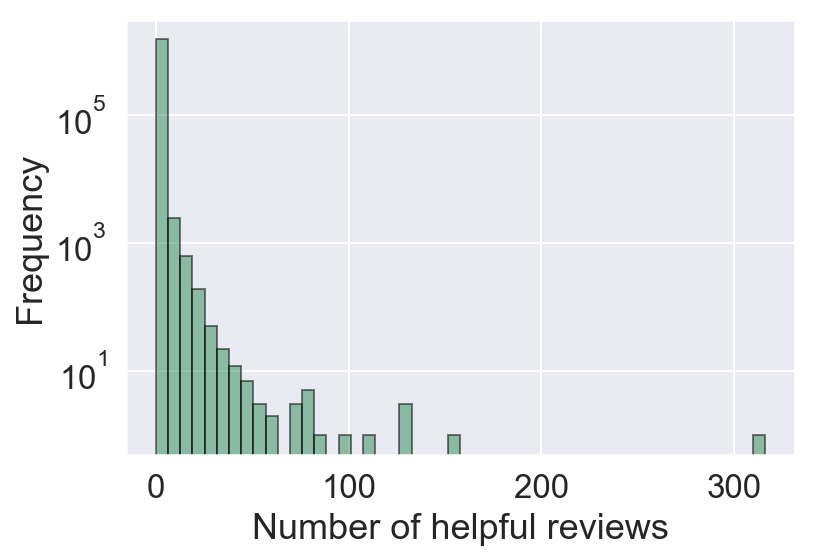

In [16]:
#looking at the distribution of helpful reviews
ax = lib_thing.n_helpful.hist(bins=50, edgecolor='black', lw=1, alpha = 0.5, color='seagreen')
ax.set_yscale('log')
ax.set_ylabel('Frequency')
_ = ax.set_xlabel('Number of helpful reviews')

In [17]:
# looking at an example of a review
lib_thing.reviews.sample().values

array(['I LOVE this book, and not just because I lived in Virginia where people are still fighting this war. Tony Horwitz can flat out write. I felt like I was traveling with him as he made his way through the Civil War locales. '],
      dtype=object)

In [18]:
# inspecting the number of unique books
lib_thing.id.nunique()

462952

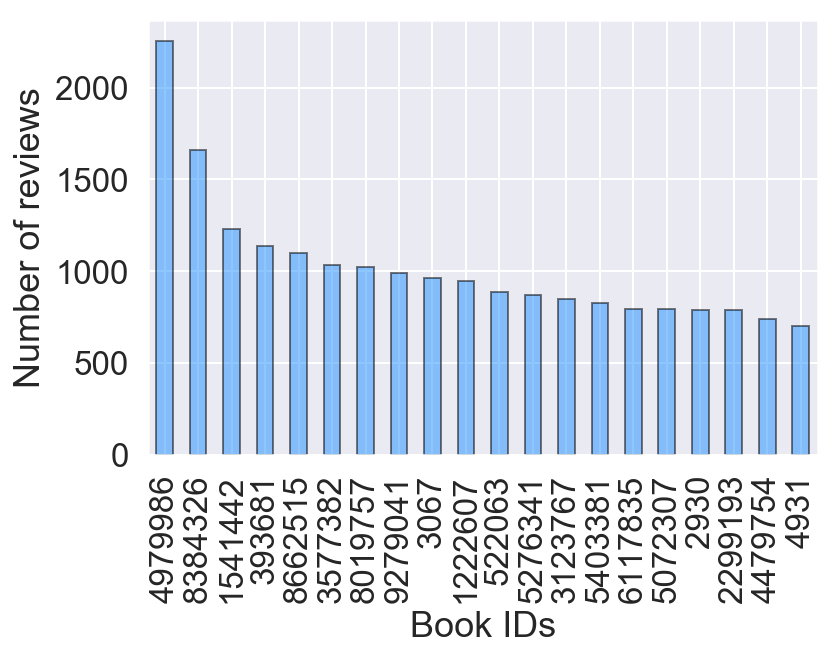

In [19]:
# visualizing the 20 books with the most reviews
ax = lib_thing.id.value_counts().head(20).plot(kind='bar', edgecolor='black', lw=1, alpha = 0.5, color='dodgerblue')
ax.set_ylabel('Number of reviews')
_ = ax.set_xlabel('Book IDs')

In [20]:
# generating a dataset with five thousand book IDs organized by decreasing number of reviews
top_5K_books = (
    lib_thing
    .id
    .value_counts()
    .head(5000)
    .rename('n_comments')
    .reset_index()
    .rename(columns={'index': 'book_id'})
)

In [21]:
# exporting this dataframe as a csv
# this will be used in my second notebook
top_5K_books.to_csv(top_5K_most_reviewed_books_path, index=False)

In [22]:
lib_thing.to_csv(lib_thing_path, index=False)